In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

(train_X, train_y), (test_X, test_y) = pickle.load(open("mnist.pkl", "rb"))
train_X = train_X / np.max(train_X)
test_X = test_X / np.max(test_X)

print(train_X.shape)

(60000, 32, 32)


In [2]:
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from functools import wraps
from time import time
from torch import nn
import torch

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size (the last chunk might be less than chunk_size) or having a total of num_chunk chunks
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

def transformation(input_data):
    data = np.zeros((len(input_data),32*32))
    for i in range(len(input_data)):
        for j in range(32):
            for k in range(32):
                data[i,31*j + k] = input_data[i,j,k]
    return data   

In [3]:
class Trainer():
    def __init__(self, model, learning_rate, epoch, batch_size):
        """ The class for training the model
        model: nn.Module
            A pytorch model
        learning_rate: float
        epoch: int
        batch_size: int
        """
        self.model = model
        self.optimizer = Adam(model.parameters(),learning_rate)           
        self.epoch = epoch
        self.batch_size = batch_size

    @timing
    def train(self, inputs, outputs, val_inputs, val_outputs,early_stop,l2,silent=False):
        """ train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures)
        val_outputs: np.array shape (ndata,)
        early_stop: bool
        l2: bool
        silent: bool. Controls whether or not to print the train and val error during training
        @return
        a dictionary of arrays with train and val losses and accuracies
        """
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.FloatTensor(inputs)
        inputs = inputs.unsqueeze(1)
        val_inputs = torch.FloatTensor(val_inputs)
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        l2_lambda=1e-5
        loss_fn = nn.CrossEntropyLoss()
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model.forward(batch_input)
                #print(batch_predictions)
                loss = loss_fn(batch_predictions,torch.LongTensor(batch_output))
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_acc
                epoch_loss += loss.detach().item()*batch_importance
                acc = torch.sum(torch.argmax(batch_predictions, axis=-1) == torch.FloatTensor(batch_output))/len(batch_predictions)
                epoch_acc += acc.detach().item()*batch_importance
                
            val_loss, val_acc = self.evaluate(val_inputs, val_outputs, print_acc=False)
            if n_epoch % 10 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
            losses.append(epoch_loss)
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()

        if early_stop:
            self.model.load_state_dict(weights)    

        return self.model,{"losses": losses, "accuracies": accuracies, "val_losses": val_losses, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        @return
        losses: float
        acc: float
        """
        loss_fn = nn.CrossEntropyLoss()
        inputs = torch.FloatTensor(inputs) 
        inputs = inputs.unsqueeze(1)
        predictions = self.model.forward(inputs)
        losses = loss_fn(predictions,torch.LongTensor(outputs)).detach().item()
        acc = torch.sum(torch.argmax(predictions, axis=-1) == torch.FloatTensor(outputs)) / len(outputs)
        acc = acc.detach().item()
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

In [4]:
from sklearn.model_selection import train_test_split,KFold

def train_and_val(model,train_X,train_y,epochs,batch_size,learning_rate,early_stop,l2,draw_curve=True):

    ### Split training examples further into training and validation ###
    train_in,valid_in,train_real,valid_real=train_test_split(train_X,train_y,test_size=1/3)
    ann_trainer = Trainer(model, learning_rate, epochs, batch_size)
    
    model,ledger  = ann_trainer.train(train_in,train_real,valid_in,valid_real,early_stop,l2)
    val_array = ledger['val_losses']
    train_array = ledger['losses']
    val_acc= ledger['val_accuracies']
    train_acc = ledger['accuracies']
       
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.plot(np.arange(len(train_array))+1,train_array,label='Training loss')        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_acc))+1,val_acc,label='Validation Accuracy')
        plt.plot(np.arange(len(train_acc))+1,train_acc,label='Training Accuracy')        
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    ### Recover the model weight ###
    weights = model.parameters()

    return model,weights 

In [5]:
def evaluate_ind(model, inputs, outputs, print_acc=True):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        @return
        losses: float
        acc: float
        """
        loss_fn = nn.CrossEntropyLoss()
        inputs = torch.FloatTensor(inputs) 
        inputs = inputs.unsqueeze(1)
        losses = loss_fn(model.forward(inputs),torch.LongTensor(outputs)).item()
        predictions = np.argmax(model.forward(inputs).detach().numpy(),axis=1)
        acc = 1 - np.count_nonzero(outputs - predictions)/len(outputs)
        if print_acc:
            print("Accuracy: %.3f" % acc)
        return losses, acc

# 1a) Without Batch normalization

In [6]:
class cnn_a1(nn.Module):
    def __init__(self):
        super(cnn_a1, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,6,kernel_size=5,stride=1,padding=0),
                                  nn.Conv2d(6,12,kernel_size=5,stride=2,padding=0)]) 
        self.pooling = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)])
        self.activation = nn.ReLU()
        
    def forward(self, x):
        for i in range(1):
            x = self.pooling(self.activation(self.conv[i](x)))
        x = nn.Flatten()(self.activation(self.conv[1](x)))
        x = self.fc[0](x)
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

  3%|█▍                                          | 1/30 [00:01<00:53,  1.85s/it]

Epoch 1/30 - Loss: 1.668 - Acc: 0.812
              Val_loss: 1.553 - Val_acc: 0.912


 37%|███████████████▊                           | 11/30 [00:20<00:35,  1.85s/it]

Epoch 11/30 - Loss: 1.486 - Acc: 0.980
              Val_loss: 1.486 - Val_acc: 0.976


 70%|██████████████████████████████             | 21/30 [00:39<00:17,  1.90s/it]

Epoch 21/30 - Loss: 1.483 - Acc: 0.984
              Val_loss: 1.486 - Val_acc: 0.975


func:'train'  took: 57.0071 sec


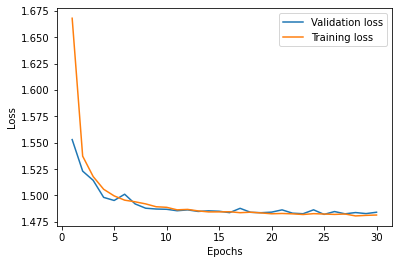

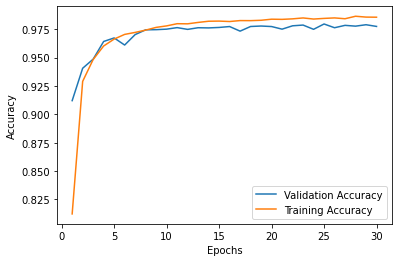

In [7]:
model_a1 = cnn_a1()
model_a1, weights_a1 = train_and_val(model_a1,train_X,train_y,epochs=30,batch_size=128,learning_rate=1e-3,early_stop=True,l2=True,draw_curve=True)

In [8]:
print('Accuracy for the original MNIST test set, Without Batch normalization')
answers_a1 = evaluate_ind(model_a1,test_X, test_y, print_acc=True)

Accuracy for the original MNIST test set, Without Batch normalization
Accuracy: 0.980


# 1a) With Batch Normalization, 0.5% better accuracy in this case

In [9]:
class cnn_a2(nn.Module):
    def __init__(self):
        super(cnn_a2, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,6,kernel_size=5,stride=1,padding=0),
                                  nn.Conv2d(6,12,kernel_size=5,stride=2,padding=0)]) 
        self.pooling = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)])
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6),nn.BatchNorm2d(12)]
        
    def forward(self, x):
        for i in range(1):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten()(self.activation(self.conv[1](x)))
        x = self.fc[0](x)
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

  3%|█▍                                          | 1/30 [00:02<01:04,  2.21s/it]

Epoch 1/30 - Loss: 1.625 - Acc: 0.850
              Val_loss: 1.527 - Val_acc: 0.939


 37%|███████████████▊                           | 11/30 [00:24<00:42,  2.22s/it]

Epoch 11/30 - Loss: 1.483 - Acc: 0.982
              Val_loss: 1.483 - Val_acc: 0.979


 70%|██████████████████████████████             | 21/30 [00:47<00:22,  2.45s/it]

Epoch 21/30 - Loss: 1.479 - Acc: 0.986
              Val_loss: 1.483 - Val_acc: 0.978


func:'train'  took: 73.2196 sec


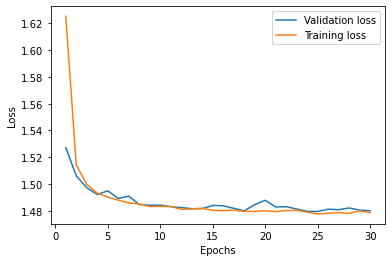

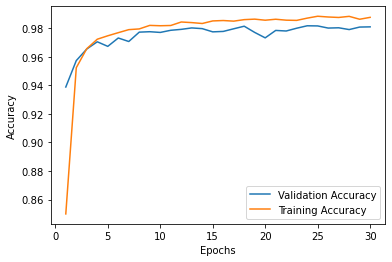

In [10]:
model_a2 = cnn_a2()
model_a2, weights_a2 = train_and_val(model_a2,train_X,train_y,epochs=30,
                                     batch_size=128,learning_rate=1e-3,early_stop=True,l2=True,draw_curve=True)

In [11]:
print('Accuracy for the original MNIST test set, With Batch normalization')
answers_a2 = evaluate_ind(model_a2,test_X, test_y, print_acc=True)

Accuracy for the original MNIST test set, With Batch normalization
Accuracy: 0.985


# 1b) With batch normalization and without skip connection, lr=5e-3, epochs=10

In [12]:
class cnn_b1(nn.Module):
    def __init__(self):
        super(cnn_b1, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,6,kernel_size=5,stride=1,padding=0),
                                  nn.Conv2d(6,12,kernel_size=5,stride=2,padding=0)]) 
        self.pooling = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)])
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6),nn.BatchNorm2d(12)]
        
    def forward(self, x):
        for i in range(1):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten()(self.activation(self.conv[1](x)))
        x = self.fc[0](x)
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

 10%|████▍                                       | 1/10 [00:02<00:21,  2.34s/it]

Epoch 1/10 - Loss: 1.560 - Acc: 0.907
              Val_loss: 1.523 - Val_acc: 0.938


func:'train'  took: 25.1972 sec


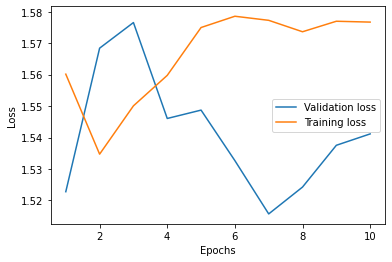

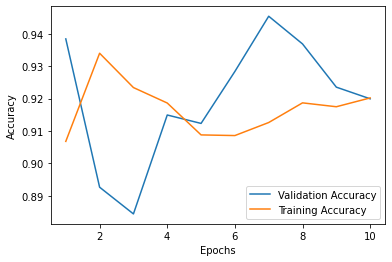

In [13]:
model_b1 = cnn_b1()
model_b1, weights_b1 = train_and_val(model_b1,train_X,train_y,epochs=10,
                                     batch_size=128,learning_rate=5e-3,early_stop=True,l2=True,draw_curve=True)

In [14]:
print('Accuracy for the original MNIST test set, With Batch normalization and without skip connection')
answers_b1 = evaluate_ind(model_b1,test_X, test_y, print_acc=True)

Accuracy for the original MNIST test set, With Batch normalization and without skip connection
Accuracy: 0.928


# 1b) With batch normalization and with skip connection, lr=5e-3, epochs=10, 1% better accuracy with skip connections

In [15]:
class cnn_b2(nn.Module):
    def __init__(self):
        super(cnn_b2, self).__init__()
        self.conv = nn.ModuleList([nn.Conv2d(1,6,kernel_size=5,stride=1,padding=0),
                                  nn.Conv2d(6,12,kernel_size=5,stride=2,padding=0)]) 
        self.pooling = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc = nn.ModuleList([nn.Linear(300,300),nn.Linear(300,10)])
        self.activation = nn.ReLU()
        self.bn = [nn.BatchNorm2d(6),nn.BatchNorm2d(12)]
        
    def forward(self, x):
        for i in range(1):
            x = self.pooling(self.activation(self.bn[i](self.conv[i](x))))
        x = nn.Flatten()(self.activation(self.conv[1](x)))
        residual =x
        x = self.fc[0](x)
        x = x+residual
        x = nn.Softmax(dim=-1)(self.fc[1](x))
        return x

 10%|████▍                                       | 1/10 [00:02<00:22,  2.45s/it]

Epoch 1/10 - Loss: 1.584 - Acc: 0.881
              Val_loss: 1.529 - Val_acc: 0.932


func:'train'  took: 25.7416 sec


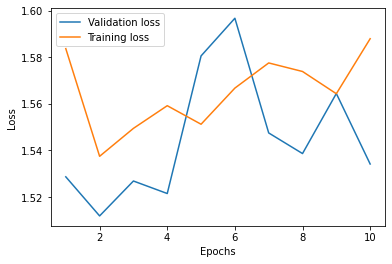

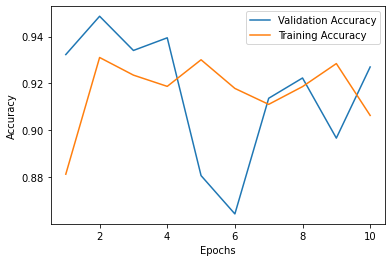

In [16]:
model_b2 = cnn_b2()
model_b2, weights_b2 = train_and_val(model_b2,train_X,train_y,epochs=10,
                                     batch_size=128,learning_rate=5e-3,early_stop=True,l2=True,draw_curve=True)

In [17]:
print('Accuracy for the original MNIST test set, Without Batch normalization and with skip connection')
answers_b2 = evaluate_ind(model_b2,test_X, test_y, print_acc=True)

Accuracy for the original MNIST test set, Without Batch normalization and with skip connection
Accuracy: 0.938
